# Exploratory Data Analysis

## PySpark Setup

In [1]:
import os
current_directory = os.getcwd()
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/jdk-23.jdk/Contents/Home"  
os.environ["SPARK_HOME"] = os.path.join(current_directory, "spark-3.5.5-bin-hadoop3")

os.environ["PATH"] = os.path.join(os.environ["SPARK_HOME"], "bin") + ":" + os.environ["PATH"]
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"

# Install necessary libraries
!pip install -q findspark
!pip install pyspark

# Initialize findspark to locate the Spark home directory
import findspark
findspark.init()

import warnings
warnings.filterwarnings("ignore")

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType,StructField, StringType, IntegerType

import pandas as pd

spark = SparkSession.builder \
    .appName("EDA") \
    .master("local[*]") \
    .config("spark.driver.extraJavaOptions", "-Djava.security.manager=allow") \
    .config("spark.executor.extraJavaOptions", "-Djava.security.manager=allow") \
    .getOrCreate()

spark.sparkContext.setLogLevel("ERROR")

print("Spark Session Created Successfully!")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/04 00:59:49 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Spark Session Created Successfully!


## Read Dataset

In [3]:
from pyspark.sql.types import StructType,StructField, StringType, IntegerType
import pandas as pd

mySchema = StructType([ StructField("index", IntegerType(), True)\
                       ,StructField("title", StringType(), True)\
                       ,StructField("author", StringType(), True)\
                       ,StructField("text", StringType(), True)\
                       ,StructField("label", IntegerType(), True)])

path = "./train.csv"
pandas_df = pd.read_csv(path, header = 0)

spark_df =spark.createDataFrame(pandas_df, schema = mySchema)
spark_df.show(10)

+-----+--------------------+--------------------+--------------------+-----+
|index|               title|              author|                text|label|
+-----+--------------------+--------------------+--------------------+-----+
|    0|House Dem Aide: W...|       Darrell Lucus|House Dem Aide: W...|    1|
|    1|FLYNN: Hillary Cl...|     Daniel J. Flynn|Ever get the feel...|    0|
|    2|Why the Truth Mig...|  Consortiumnews.com|Why the Truth Mig...|    1|
|    3|15 Civilians Kill...|     Jessica Purkiss|Videos 15 Civilia...|    1|
|    4|Iranian woman jai...|      Howard Portnoy|Print \nAn Irania...|    1|
|    5|Jackie Mason: Hol...|     Daniel Nussbaum|In these trying t...|    0|
|    6|Life: Life Of Lux...|                 NaN|Ever wonder how B...|    1|
|    7|Benoît Hamon Wins...|     Alissa J. Rubin|PARIS  —   France...|    0|
|    8|Excerpts From a D...|                 NaN|Donald J. Trump i...|    0|
|    9|A Back-Channel Pl...|Megan Twohey and ...|A week before Mic...|    0|

## Distinct Authors

In [4]:
# Distinct Authors
(spark_df
    .filter(spark_df["author"] != "NaN")    # Remove NaN values (missing values)
    .select("author")                       # Select author attribute
    .rdd                                    # Conver to RDD
    .map(lambda x: x[0].lower())            # Convert to lower case letters
    .distinct()                             # Get unique author values
    .count()                                # Count distinct authors
)


/Users/bhavyajain/Desktop/sem6/ai_hardware/apache-spark-project/spark-3.5.5-bin-hadoop3/python/lib/pyspark.zip/pyspark/shuffle.py:65: UserWarning: Please install psutil to have better support with spilling
/Users/bhavyajain/Desktop/sem6/ai_hardware/apache-spark-project/spark-3.5.5-bin-hadoop3/python/lib/pyspark.zip/pyspark/shuffle.py:65: UserWarning: Please install psutil to have better support with spilling
/Users/bhavyajain/Desktop/sem6/ai_hardware/apache-spark-project/spark-3.5.5-bin-hadoop3/python/lib/pyspark.zip/pyspark/shuffle.py:65: UserWarning: Please install psutil to have better support with spilling
/Users/bhavyajain/Desktop/sem6/ai_hardware/apache-spark-project/spark-3.5.5-bin-hadoop3/python/lib/pyspark.zip/pyspark/shuffle.py:65: UserWarning: Please install psutil to have better support with spilling
/Users/bhavyajain/Desktop/sem6/ai_hardware/apache-spark-project/spark-3.5.5-bin-hadoop3/python/lib/pyspark.zip/pyspark/shuffle.py:65: UserWarning: Please install psutil to have

4194

## Class Size

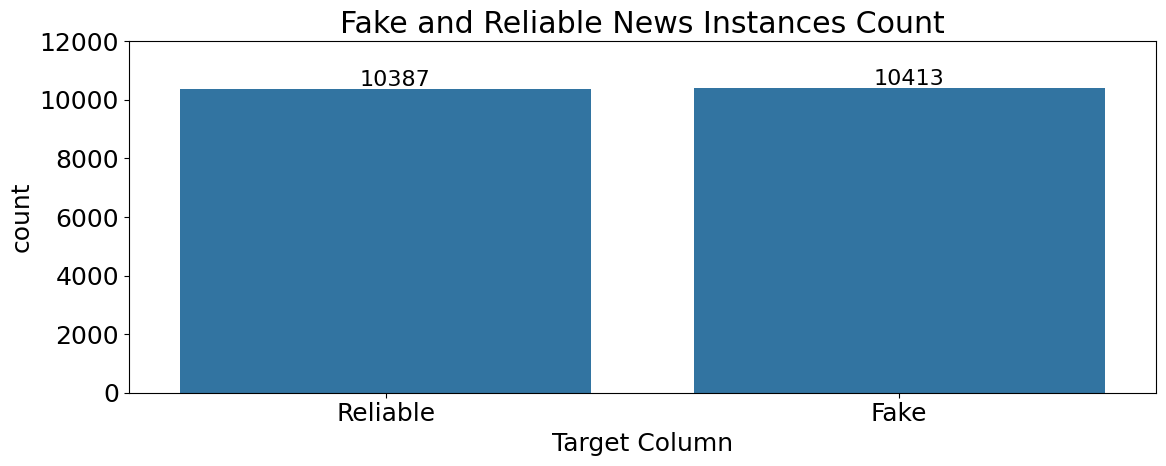

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = [12, 5]
plt.rcParams["figure.autolayout"] = True
plt.rcParams.update({'font.size': 18})
df = pd.DataFrame(dict(col1=spark_df.select("label").rdd.map(lambda x: x[0]).collect()))

ax = sns.countplot(x="col1", data=df)
ax.set_ylim([0, 12000])
ax.set_xlabel("Target Column")
ax.set_title("Fake and Reliable News Instances Count")
ax.set_xticklabels(["Reliable", "Fake"])

for patch in ax.patches:
   ax.annotate('{:.0f}'.format(patch.get_height()),                # Count
               (patch.get_x()+0.35, patch.get_height()+100),          # x,y coordinates for label.
               fontsize=16)   
   
plt.show()

## Text is missing

In [7]:
df_no_text = spark_df.filter(spark_df["text"] == "NaN")

print("Text is NaN: " + str(df_no_text.count()) + " Rows")
df_no_text.filter(df_no_text["author"] == "NaN").count()

Text is NaN: 39 Rows


39

In [9]:
df_no_text.filter(df_no_text["title"] == "NaN").count()

0

In [10]:
df_no_text.filter(df_no_text["label"] == 1).count() == df_no_text.count()

True

1. There are 39 rows missing text
1. All text missing rows are also missing the author!
2. All text missing rows are fake!

## Title is missing

In [ ]:
df_no_title = spark_df.filter(spark_df["title"] == "NaN")


In [ ]:
df_no_title.filter(df_no_title["author"] == "NaN").count() # 0
df_no_title.filter(df_no_title["text"] == "NaN").count() # 0

In [ ]:
df_no_title.filter(df_no_title["label"] == 1).count() == df_no_title.count()

In [ ]:
df_no_title.count()

1. There are 558 rows missing a title!
1. All rows missing title, do not also miss both author and text values
1. All rows missing title are fake!


## Author is missing

In [ ]:
df_no_author = spark_df.filter(spark_df["author"] == "NaN")
df_no_author.count()

In [ ]:
df_no_author.filter(df_no_author["label"] == 1).count()

In [ ]:
df_no_author.filter(df_no_author["label"] == 0).count()

In [ ]:
1957+558
(2515-26)/2515

1. There are 1957 rows missing an author!
1. Among these 1957 rows, 1931 are fake and 26 are reliable!
1. Overall missing values could indicate fake news since the majority of rows missing one or more values are also fake. In other words: 
There are 1957 rows missing an author and an additional 558 rows missing a title. The rows missing the text are included since they are all missing the author as well. Overall there are 2515 rows missing one or more feature. 26 of them are marked as reliable which means that 98.96% of all rows missing at least one feature are fake!

## Not missing at all

In [ ]:
df_all_features = (spark_df
                    .filter(spark_df["author"] != "NaN")
                    .filter(spark_df["title"] != "NaN"))

df_all_features.count()

In [ ]:
df_all_features.filter(df_all_features["label"] == 0).count()

In [ ]:
from pyspark.sql.functions import col
df_all_features.filter(col("label") == 1).count()

1. There are 18,285 rows that are not missing any feature
1. 10,361 out of these rows are reliable, whereas the other 7,924 are marked as fake!
